# Classic English Literature
https://www.kaggle.com/code/raynardj/starter-classic-english-literature

In [3]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine as ce
from sqlalchemy import inspect
from pathlib import Path

### Connection¶
Data is a SQLite database file, entire database, single tiny file

In [4]:
DATA= Path("./books.db")

engine = ce("sqlite:///"+str(DATA))
inspector = inspect(engine)

In [5]:
# table names
inspector.get_table_names()

['authors', 'book_file', 'book_original', 'books', 'text_files']

In [6]:
books_df = pd.read_sql("books", con = engine)
books_df

,book_id,bookname,author_id,cate1
0,0,'twixt Land & Sea,167,English Literature
1,1,"20,000 Leagues Under The Sea",169,Translated Works
2,2,50 Bab Ballads,287,English Literature
3,3,A Cathedral Courtship,172,English Literature
4,4,A Child's Garden Of Verses,226,English Literature
...,...,...,...,...
1082,1082,Woman And Labour,207,English Literature
1083,1083,Women In Love,50,English Literature
1084,1084,Wuthering Heights,75,English Literature
1085,1085,Yankee Gypsies,156,English Literature


In [7]:
# author table, for born and death columns, 10000 is for missing data

author_df = pd.read_sql("authors", con = engine)
author_df

,index,author,born,death
0,0,Adam Ferguson,1723,1816
1,1,Adam Smith,1723,1790
2,2,Aeschylus,525,10000
3,3,Aesop,10000,10000
4,4,Alan Seeger,1888,1916
...,...,...,...,...
287,287,William S.gilbert,1836,1911
288,288,William Shakespeare,1564,1616
289,289,William Thackeray,1811,1863
290,290,Xenophon,10000,10000


In [8]:
# book_file table. A mapping relationship between book metadata and text content(in most cases chapter levle) of the book

book_file_df = pd.read_sql("book_file", con = engine)
book_file_df

,index,file_id,book_id,chapter
0,0,0,943,Nan
1,1,1,54,Nan
2,2,2,681,25-khalifah
3,3,3,681,Entertainments
4,4,4,681,02-the Fishmerman And The Jinni
...,...,...,...,...
10166,10166,10130,106,Volumeone-part01
10167,10167,10131,106,Volumeone-part03
10168,10168,10132,106,Volumeone-part02
10169,10169,10133,106,Volumeone-part05


In [9]:
text_files_df = pd.read_sql("text_files", con = engine)
text_files_df

,index,fmt,text
0,0,txt,\n\n\n\n\n\n\n\nThe Song of Roland\n\n\n\n\n\n...
1,1,txt,\n\n\n\n\n\n\n\n\n\n\t\tAesop's Fables \n\n\n\...
2,2,txt,\n\n\n\n\n\n\n\n\n\n KHALIFAH THE...
3,3,txt,\n\n\n\n\n\n\n\n\n\n ...
4,4,txt,\n\n\n\n\n\n\n\n\n\n THE FISHE...
...,...,...,...
10166,10166,txt,\n\n\n\n\n\n\n\nIII\n\n\n\n\n\n\n\n\n\n\n\nCha...
10167,10167,txt,\n\n\n\n\n\n\n\nII\n\n\n\n\n\n\n\n\n\n\n\nOn w...
10168,10168,txt,\n\n\n\n\n\n\n\nBook Fifth\n\n\n\n\n\n\n\n\n\n...
10169,10169,txt,\n\n\n\n\n\n\n\nII\n\n\n\n\n\n\n\n\n\n\n\nStre...


### Helper Functions

In [10]:
def searchAuthor(kw):
    return author_df[author_df.author.str.contains(kw)]

def searchBookByAuthor(kw):
    author_result = list(searchAuthor(kw).index)
    return books_df[books_df.author_id.isin(author_result)]

### Data Model
Since this is a RMDBS, let's map the data orm models to make things easier

In [11]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Text, ForeignKey
from sqlalchemy.orm import relationship
Base = declarative_base()

def getSession(engine):
    from sqlalchemy.orm import sessionmaker
    return sessionmaker()(bind=engine)

class authorModel(Base):
    __tablename__ = 'authors'
    index = Column(Integer, primary_key = True)
    author = Column(Text)
    born = Column(Integer)
    death = Column(Integer)
    
    def __repr__(self):
        return "<Author: %s, %s to %s>"%(self.author,self.born_year,self.death_year)
    
    @property
    def born_year(self):
        if self.born < 9999: return self.born
        else: return "No Record"

    @property
    def death_year(self):
        if self.death < 9999: return self.death
        else: return "No Record"

class chapterModel(Base):
    __tablename__ = "text_files"
    index = Column(Integer, primary_key = True)
    fmt = Column(Text) # Format
    text = Column(Text) # Text content
    
    def __repr__(self):
        return "book file:%s"%(self.index)
    
class bookModel(Base):
    __tablename__ = "books"
    book_id = Column(Integer, primary_key = True)
    bookname = Column(Text)
    cate1 = Column(Text)
    author_id = Column(Integer,ForeignKey(authorModel.index))
    author = relationship(authorModel)
    
    def __repr__(self):
        return "<Book: %s>"%(self.bookname)
    
class bookChapterModel(Base):
    __tablename__ = "book_file"
    index = Column(Integer, primary_key = True)
    file_id = Column(Integer,ForeignKey(chapterModel.index))
    book_id = Column(Integer,ForeignKey(bookModel.book_id))
    file = relationship(chapterModel)
    book = relationship(bookModel)
    chapter = Column(Text())

    def __repr__(self):
        return "Book:%s with File:%s, Chapter:%s"%(self.book,self.file,self.chapter)
    
bookModel.maps = relationship(bookChapterModel)
bookModel.chapters = relationship(chapterModel, secondary = "book_file")
chapterModel.books = relationship(bookModel, secondary = "book_file")
chapterModel.maps = relationship(bookChapterModel)
authorModel.books = relationship(bookModel)

/var/folders/6v/v631xqn50t3dl170t0r4zcwm0000gn/T/ipykernel_13223/3566640638.py:4: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [12]:
sess = getSession(engine)
sess.query(authorModel).all()

/var/folders/6v/v631xqn50t3dl170t0r4zcwm0000gn/T/ipykernel_13223/3259970672.py:2: SAWarning: relationship 'chapterModel.maps' will copy column text_files.index to column book_file.file_id, which conflicts with relationship(s): 'chapterModel.books' (copies text_files.index to book_file.file_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="books"' to the 'chapterModel.maps' relationship. (Background on this warning at: https://sqlalche.me/e/20/qzyx) (This warning originated from the `configure_mappers()` process, which was invoked automatically in response to a user-initiated operation.)
  sess.query(authorModel).all()
/var/folde

[<Author: Adam Ferguson, 1723 to 1816>,
 <Author: Adam Smith  , 1723 to 1790>,
 <Author: Aeschylus, 525 to No Record>,
 <Author: Aesop, No Record to No Record>,
 <Author: Alan Seeger, 1888 to 1916>,
 <Author: Alexander H.japp, 1839 to 1905>,
 <Author: Alexander Hamilton, 1755 to 1804>,
 <Author: Alexandre Dumas, 1802 to 1870>,
 <Author: Alfred Marshall  , 1842 to 1924>,
 <Author: Alfred Tennyson, 1809 to 1892>,
 <Author: Alice Meynell, 1847 to 1924>,
 <Author: Ambrose Bierce, 1842 to 1914>,
 <Author: Amy Lowell, 1874 to 1925>,
 <Author: Anatole France, No Record to No Record>,
 <Author: Andrew Barton Paterson, 1864 to 1941>,
 <Author: Andrew Dickson White, 1832 to 1918>,
 <Author: Andrew Lang, 1844 to 1912>,
 <Author: Andrew Steinmetz, 1816 to 1877>,
 <Author: Anna Howard Shaw, 1847 to 1919>,
 <Author: Anna Sewell, 1820 to 1878>,
 <Author: Anne Bronte, 1820 to 1849>,
 <Author: Anne-robert-jacques Turgot  , 1727 to 1781>,
 <Author: Anthony Hope, 1863 to 1933>,
 <Author: Antony Trollope,

In [13]:
test_author = sess.query(authorModel).filter_by(index=64).first()
test_author

<Author: Edward Gibbon  , 1737 to 1794>

In [14]:
test_author.books[:5]

[<Book: History Of Roman-1>,
 <Book: History Of Roman-2>,
 <Book: History Of Roman-3>,
 <Book: History Of Roman-4>,
 <Book: History Of Roman-5>]

In [15]:
test_book = test_author.books[2]
test_book

<Book: History Of Roman-3>

In [16]:
test_book.chapters

[book file:8150,
 book file:8151,
 book file:8152,
 book file:8153,
 book file:8154,
 book file:8155,
 book file:8156,
 book file:8157,
 book file:8158,
 book file:8159,
 book file:8160,
 book file:8161,
 book file:8162]

In [17]:
#Check the content of a chapter

print(test_book.chapters[0].text[:1000])













Chapter XXXVI: Total Extinction Of The Western Empire. 







Part I.







     Sack Of Rome By Genseric, King Of The Vandals. - His Naval



Depredations. - Succession Of The Last Emperors Of The West,



Maximus, Avitus, Majorian, Severus, Anthemius, Olybrius,



Glycerius, Nepos, Augustulus. - Total Extinction Of The Western



Empire. - Reign Of Odoacer, The First Barbarian King Of Italy.  



     The loss or desolation of the provinces, from the Ocean to



the Alps, impaired the glory and greatness of Rome: her internal



prosperity was irretrievably destroyed by the separation of



Africa.  The rapacious Vandals confiscated the patrimonial



estates of the senators, and intercepted the regular subsidies,



which relieved the poverty and encouraged the idleness of the



plebeians.  The distress of the Romans was soon aggravated by an



unexpected attack; and the province, so long cultivated for their



use by industrious and obedient subjects, was armed aga

In [37]:
from nltk.tokenize import sent_tokenize
# import nltk.data

# tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
text = test_book.chapters[0].text
# text = 'Some sentence. Mr. Holmes...This is a new sentence!And This is another one.. Hi '
sentences = sent_tokenize(text)
# strip newline characters from sentences
sentences = [s.replace('\n', '') for s in sentences]

sentences[:10]


['Chapter XXXVI: Total Extinction Of The Western Empire.',
 'Part I.     Sack Of Rome By Genseric, King Of The Vandals.',
 '- His NavalDepredations.',
 '- Succession Of The Last Emperors Of The West,Maximus, Avitus, Majorian, Severus, Anthemius, Olybrius,Glycerius, Nepos, Augustulus.',
 '- Total Extinction Of The WesternEmpire.',
 '- Reign Of Odoacer, The First Barbarian King Of Italy.',
 'The loss or desolation of the provinces, from the Ocean tothe Alps, impaired the glory and greatness of Rome: her internalprosperity was irretrievably destroyed by the separation ofAfrica.',
 'The rapacious Vandals confiscated the patrimonialestates of the senators, and intercepted the regular subsidies,which relieved the poverty and encouraged the idleness of theplebeians.',
 'The distress of the Romans was soon aggravated by anunexpected attack; and the province, so long cultivated for theiruse by industrious and obedient subjects, was armed against themby an ambitious Barbarian.',
 "The Vandals an

In [132]:
# function that given an author index, returns list of sentences in all of their books
def get_sentences(author_index):
    author = sess.query(authorModel).filter_by(index=author_index).first()
    books = author.books
    sentences = []
    for book in books:
        for chapter in book.chapters:
            text = chapter.text
            temp = sent_tokenize(text)
            # strip newline characters and lower case sentences
            sentences += [s.replace('\n', '').lower() for s in temp] # strip newline characters from sentences
    return sentences

In [133]:
from sklearn.model_selection import train_test_split

In [134]:
author64_sentences = get_sentences(64)
author3_sentences = get_sentences(63)

# split the sentences into a training set and a test set
author64_train, author64_test = train_test_split(author64_sentences, test_size=0.2, random_state=42)
author3_train, author3_test = train_test_split(author3_sentences, test_size=0.2, random_state=42)

print(len(author64_sentences), len(author64_train), len(author64_test))
print(len(author3_sentences), len(author3_train), len(author3_test))

# create labels for the sentences
author64_train_labels = [0]*len(author64_train)
author64_test_labels = [0]*len(author64_test)
author3_train_labels = [1]*len(author3_train)
author3_test_labels = [1]*len(author3_test)

# combine the training sentences and labels into np arrays
author64_train = np.array(author64_train)
author64_train_labels = np.array(author64_train_labels)
author3_train = np.array(author3_train)
author3_train_labels = np.array(author3_train_labels)

# combine the test sentences and labels into np arrays
author64_test = np.array(author64_test)
author64_test_labels = np.array(author64_test_labels)
author3_test = np.array(author3_test)
author3_test_labels = np.array(author3_test_labels)

# combine the trainign and testing arrays from the authors
train_sentences = np.concatenate((author64_train, author3_train))
train_labels = np.concatenate((author64_train_labels, author3_train_labels))
test_sentences = np.concatenate((author64_test, author3_test))
test_labels = np.concatenate((author64_test_labels, author3_test_labels))



80524 64419 16105
8160 6528 1632


In [135]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

# Plot Utility from NLTK course

In [136]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# LSTM model

In [137]:
embedding_dim = 16
lstm_dim = 64
dense_dim = 64

# Import the tensorflow libraries
import tensorflow as tf

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 120, 16)           160000    
                                                                 
 bidirectional_16 (Bidirect  (None, 128)               41472     
 ional)                                                          
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 209793 (819.50 KB)
Trainable params: 209793 (819.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [139]:
num_epochs = 10
batch_size = 128

history_lstm = model_lstm.fit(
    padded, 
    train_labels, 
    epochs=num_epochs, 
    batch_size=batch_size, 
    validation_data=(testing_padded, test_labels), 
    verbose=2)

Epoch 1/10


KeyboardInterrupt: 

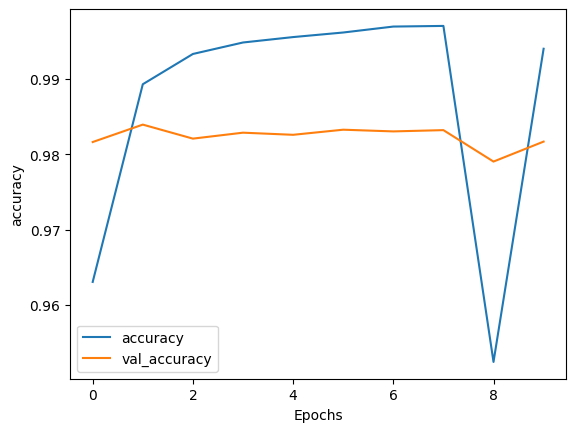

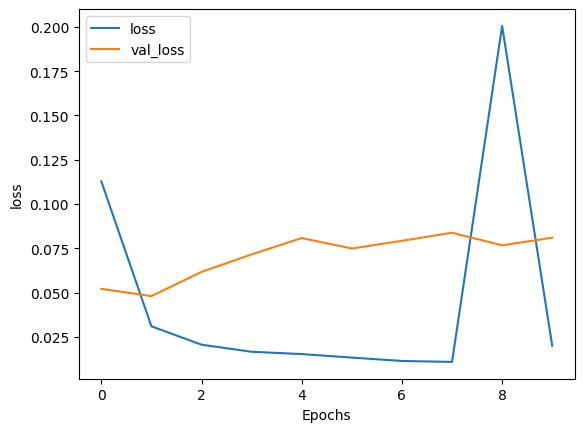

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

# Try on 10 authors

In [145]:
# get sentences for 10 authors
num_authors = 10
sentences = {}
for i in range(num_authors):
    sentences[i] = get_sentences(i)
    print(len(get_sentences(i)))

# split into train and test sets
train_sentences = {}
test_sentences = {}
for i in range(num_authors):
    train_sentences[i], test_sentences[i] = train_test_split(sentences[i], test_size=0.2, random_state=42)

# combine the training sentences into np array list
train_sentences_combined = []
train_labels = []
for i in range(num_authors):
    train_sentences_combined += train_sentences[i]
    train_labels += [i] * len(train_sentences[i])

train_sentences = np.array(train_sentences_combined)
train_labels = np.array(train_labels)

# combine the test sentences into np array list
test_sentences_combined = []
test_labels = []
for i in range(num_authors):
    test_sentences_combined += test_sentences[i]
    test_labels += [i] * len(test_sentences[i])

test_sentences = np.array(test_sentences_combined)
test_labels = np.array(test_labels)

# find how many unique words there are in the training sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print("vocab size of training sentences:", vocab_size)

# get statistics on the length of the sentences
lengths = []
for sentence in train_sentences:
    lengths.append(len(sentence))
# get average, median, min and max lengths
print("average sentence length:", np.mean(lengths))
print("median sentence length:", np.median(lengths))
print("min sentence length:", np.min(lengths))
print("max sentence length:", np.max(lengths))


# randomise the order of the training sentences and labels
# randomize = np.arange(len(train_sentences))
# np.random.shuffle(randomize)
# train_sentences = train_sentences[randomize]
# train_labels = train_labels[randomize]


2976
16179
2791
1599
1339
2202
6121
81248
4391
3537
vocab size of training sentences: 105460
average sentence length: 116.04279833709563
median sentence length: 87.0
min sentence length: 1
max sentence length: 10600


In [146]:
# Parameters
vocab_size = 10000 * num_authors
max_length = 60
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,maxlen=max_length)

# format the labels into 1-hot vectors - only do the following for categorical entropy, sparse categorical entropy does not need this
# train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = num_authors)
# test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = num_authors)

In [147]:
# define an GRU model
embedding_dim = 16
lstm_dim = 32
dense_dim = 16

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(num_authors, activation='softmax')
])

# optimizer = tf.keras.optimizers.Adam(lr=0.001) # try a different learning rate because accuracy was suddenly dropping and got nan loss
# model_gru.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

model_gru.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 60, 16)            1600000   
                                                                 
 bidirectional_19 (Bidirect  (None, 64)                9600      
 ional)                                                          
                                                                 
 dense_38 (Dense)            (None, 16)                1040      
                                                                 
 dense_39 (Dense)            (None, 10)                170       
                                                                 
Total params: 1610810 (6.14 MB)
Trainable params: 1610810 (6.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [148]:
# fit the model
num_epochs = 10
batch_size = 128

history_gru = model_gru.fit(
    padded, 
    train_labels, 
    epochs=num_epochs, 
    batch_size=batch_size, 
    validation_data=(test_padded, test_labels), 
    verbose=2)

Epoch 1/10
765/765 - 328s - loss: 0.8790 - accuracy: 0.7604 - val_loss: 4.1025 - val_accuracy: 0.5017 - 328s/epoch - 428ms/step
Epoch 2/10
765/765 - 227s - loss: 0.5693 - accuracy: 0.8331 - val_loss: 3.9356 - val_accuracy: 0.5134 - 227s/epoch - 296ms/step
Epoch 3/10
765/765 - 226s - loss: 0.4622 - accuracy: 0.8667 - val_loss: 3.5977 - val_accuracy: 0.5533 - 226s/epoch - 295ms/step
Epoch 4/10
765/765 - 285s - loss: 0.3843 - accuracy: 0.8881 - val_loss: 3.6070 - val_accuracy: 0.5572 - 285s/epoch - 373ms/step
Epoch 5/10
765/765 - 236s - loss: 0.3152 - accuracy: 0.9066 - val_loss: 3.5890 - val_accuracy: 0.5511 - 236s/epoch - 308ms/step
Epoch 6/10
765/765 - 198s - loss: 0.2664 - accuracy: 0.9211 - val_loss: 3.7787 - val_accuracy: 0.5520 - 198s/epoch - 259ms/step
Epoch 7/10
765/765 - 230s - loss: 0.2258 - accuracy: 0.9337 - val_loss: 3.0257 - val_accuracy: 0.5752 - 230s/epoch - 300ms/step
Epoch 8/10
765/765 - 301s - loss: 0.1929 - accuracy: 0.9430 - val_loss: 2.5976 - val_accuracy: 0.5959 - 

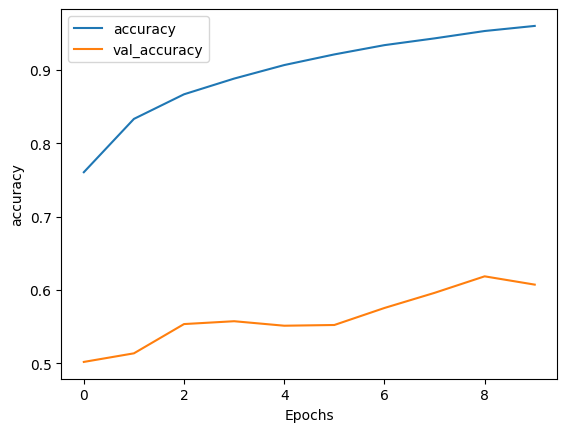

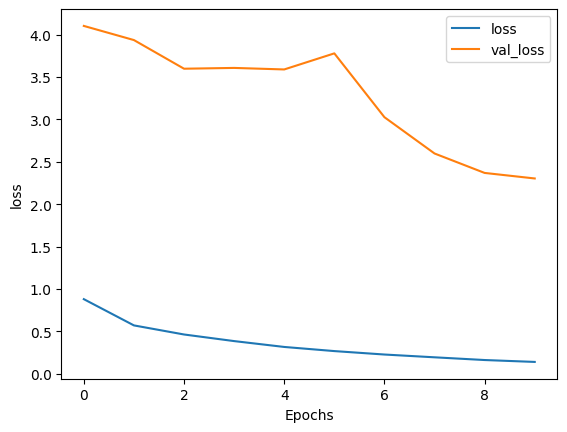

In [149]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')